## **Importing necessary libraries**

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time  
from tqdm import tqdm
from IPython import display

# **Loading and Preprocessing the dataset**



*   For training we are using mnist dataset
      * It was constructed from NIST's Special Database 3 and Special Database 1 which contain binary images of handwritten digits.
      * It contain 60,000 training cases and 10,000 test cases of handwritten digits (0 to 9)
      * Each digit is normalized and centered in a gray-scale (0 - 255) image with size 28 × 28. 
      * Each image consists of 784 pixels that represent the features of the digits.
*   To scale the dataset values between -1 and +1 we subtract and divide it by 127.5 
*   Then we divided the dataset into batches of 64 for faster training.






In [2]:
(train_image , train_label) , (test_image , test_label) = tf.keras.datasets.mnist.load_data()

train_image.shape

11501568/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [3]:
train_image = train_image.reshape(train_image.shape[0] , 28 , 28 , 1).astype('float32')
train_image = (train_image - 127.5)/127.5
train_image.shape

(60000, 28, 28, 1)

In [4]:
buffer_size = 60000
batch_size = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_image)
train_dataset = train_dataset.shuffle(buffer_size)
train_dataset = train_dataset.batch(batch_size)

# **Building Generator Model**
### The Generator model take's input a random noise and upscale the random image. Generated image gets better with every epoch. The main aim of the generator model is to create a real looking image in order to fool the discriminator.


In [5]:

def generator_model () :
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256 , use_bias = False , input_shape = (100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Here we use assert funciton to check wether we are getting desired shape or not 
  # Conv2DTranspose to upscale the image and apply convolution to it
  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None, 7, 7, 256) #None is the batch size 
  
  model.add(layers.Conv2DTranspose(128 , (5,5), strides=(1,1), padding='same', use_bias= False))  
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5,5), strides= (2,2), padding='same', use_bias= False, activation='tanh')) 
  assert model.output_shape == (None, 28, 28, 1)

  return model



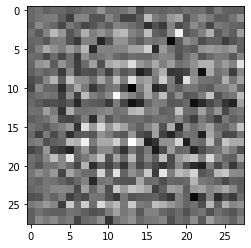

In [6]:
generator = generator_model()

#Creating a random noise image which we will feed in generator model 
noise = tf.random.normal([1,100])
generated_image = generator(noise , training = False)
plt.imshow(generated_image[0,: ,:,0],cmap='gray')

In [7]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

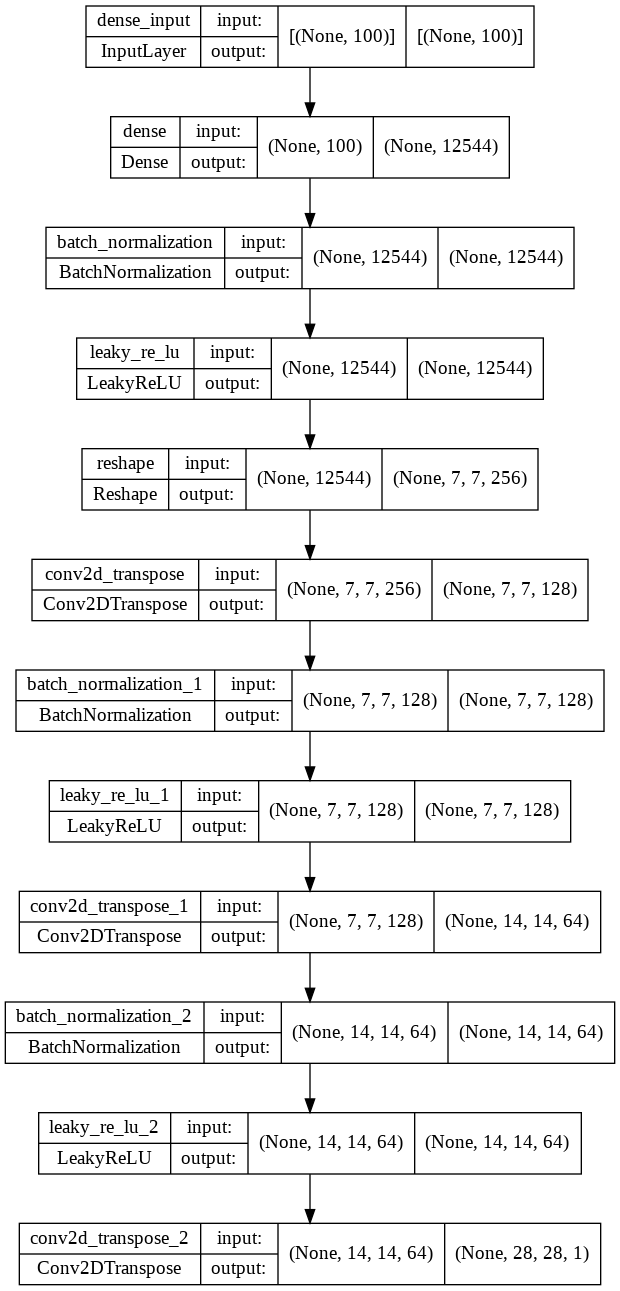

In [8]:

tf.keras.utils.plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

# **Build Discriminator Model**

In [9]:
def discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides = (2,2), padding = 'same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.30))

  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation = 'sigmoid'))

  return model


In [10]:
discriminator = discriminator_model()
result = discriminator(generated_image)
result

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5001566]], dtype=float32)>

In [11]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

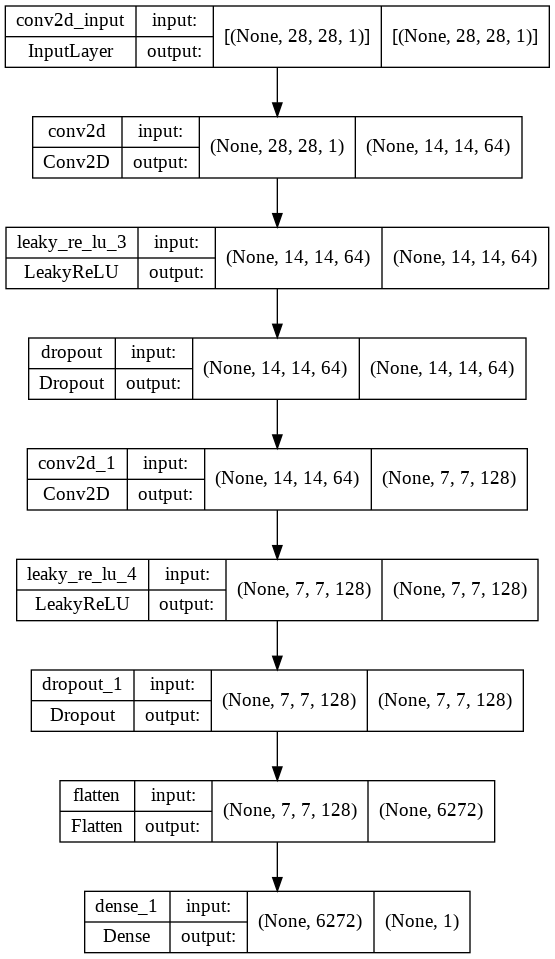

In [12]:

tf.keras.utils.plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

# **Custom Loss Function**

we are creating custom loss function because discriminator and generator model both behaves differently when given real and fake images 

We get output as 1 when discriminator sense that the given image is real and 0 when it sense that it output fake image 

Ideally we want discrimintor to give 1 for every real image and 0 for all fake iamge. We also want generator to give real image every time therefore the expected output is 1. 



In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [14]:
def discriminator_loss (real_output , fake_output) :
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output) , fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [15]:
def generator_loss (fake_output) :
  return cross_entropy(tf.ones_like(fake_output) , fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Creating Checkpoints to save model weight and optimizer weights 


In [17]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir , "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate , noise_dim])

# Creating custom training steps for every epochs


In [19]:
# @tf.function will cause the function to be compiled in tensorflow pattern

@tf.function 
def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    generated_image = generator(noise, training = True)

    real_output = discriminator(images , training = True)
    fake_output = discriminator(generated_image , training = True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output , fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss , generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss , discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))


# To generate and visualize images after every epoch

In [20]:
def generate_and_save_images (model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize = (4,4))
  for i in range (predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i, :, :, 0]*127.5 + 127.5 , cmap='gray')
    plt.axis('off')
  
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()




In [21]:
def train (dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in tqdm(dataset):
      train_step(image_batch)
    # Display and clear iamges after each epoch
    display.clear_output(wait = True)
    generate_and_save_images(
        generator, 
        epoch + 1 ,
        seed
    )

    #To save the model after every 15 epochs
    if(epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))
  
  # Generate image after every epoch 
  display.clear_output(wait = True)
  generate_and_save_images(generator,
                           epochs,
                           seed
  )



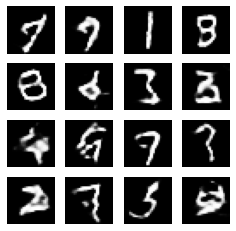

In [22]:
train(train_dataset, EPOCHS)